### Importing the libraries

In [1]:
import pandas as pd  # other libraries imported lated on
import numpy as np

### Loading data

In [ ]:
data = pd.read_csv("./drive/My Drive/DATASET/news.csv") # trained on google colab with cloud GPU

### Data exploration and Preprocessing

In [4]:
data.shape #Total 6335 articles

(6335, 4)

In [6]:
data.head() # already shuffled

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [7]:
data.isnull().sum() # no null entry

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [8]:
import string  # data cleaning
def clean_text(text):
    words = str(text).split()
    words = [i.lower() + " " for i in words]
    words = " ".join(words)
    words = words.translate(words.maketrans('', '', string.punctuation))
    words = words.replace('—','')  #kaydee king line
    return words

data['text'] = data['text'].apply(clean_text)
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,daniel greenfield a shillman journalism f...,FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,google pinterest digg linkedin reddit stu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,us secretary of state john f kerry said...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,kaydee king kaydeeking november 9 2016 ...,FAKE
4,875,The Battle of New York: Why This Primary Matters,its primary day in new york and frontru...,REAL


### Splitting the dataset

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train, test = train_test_split(data, test_size = 0.07)
train, validation = train_test_split(train, test_size = 0.03)
print(len(train), len(validation), len(test) )

5714 177 444


In [10]:
train.head()

,Unnamed: 0,title,text,label
6274,10086,BREAKING: WikiLeaks Just Released Full ISIS Do...,in government government corruption ob...,FAKE
5702,7514,News: Democracy Win: Volunteers Across The Cou...,email despite the fact that voting is t...,FAKE
1454,8366,Badass Patriot Has MASSIVE Surprise For Thieve...,badass patriot has massive surprise for ...,FAKE
4203,6636,Comment on 10 More Beautiful Images That Remin...,share on facebook share on twitter it s...,FAKE
2687,8162,2:00PM Water Cooler 11/1/2016,by lambert strether of corrente ttp tt...,FAKE


### Tokenizing and forming padded sequences (Data Preparation)

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
vocab_size = 10000
trunc_type = "post"
pad_type = "post"
oov_tok = "<OOV>"  #Out Of Vocab token
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok) # tokenizer instance wrt vocab size and oov token
tokenizer.fit_on_texts(train.text)  # only 'text' from 'train' dataframe will be taken for model training
word_index = tokenizer.word_index

In [13]:
training_sequences = tokenizer.texts_to_sequences(np.array(train.text)) # data converted to sequences using tokenizer instance 
training_padded = pad_sequences(training_sequences,truncating=trunc_type, padding=pad_type) # padded sequence with type = post

max_length = len(training_padded[0])

validation_sequences = tokenizer.texts_to_sequences(np.array(validation.text))
validation_padded = pad_sequences(validation_sequences, padding=pad_type, truncating=trunc_type, maxlen = max_length)

In [14]:
train_x = np.copy(training_padded)  # inputs assigned
validate_x = np.copy(validation_padded)

In [15]:
# targets assigned
train_y = train['label'].replace('FAKE',1).replace('REAL',0).values  #numpy array # binary encoding
validate_y = validation['label'].replace('FAKE',1).replace('REAL',0).values

In [16]:
print(len(train_x), len(train_y))

5714 5714


The above data prep step is done in order to integer-encode the words so that they may be used by the model below

### Defining the model architecture

In [16]:
import tensorflow as tf

In [40]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 16, input_length=max_length), #16 = size of the vector space in which words will be embedded
    #The Embedding layer is initialized with random weights and will learn an embedding 
    #for all of the words in the training dataset. That's why integer-encoded words were required.
    #The embedding is learned along with the model itself?
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  metrics=['accuracy'])

### Training the model

In [41]:
history = model.fit(train_x, train_y, verbose = 2, epochs = 10, validation_data = (validate_x, validate_y),
                   callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=6)])

Epoch 1/10
179/179 - 9s - loss: 0.6385 - accuracy: 0.7072 - val_loss: 0.4972 - val_accuracy: 0.8192
Epoch 2/10
179/179 - 9s - loss: 0.3690 - accuracy: 0.8668 - val_loss: 0.2630 - val_accuracy: 0.9153
Epoch 3/10
179/179 - 9s - loss: 0.2008 - accuracy: 0.9340 - val_loss: 0.1965 - val_accuracy: 0.9096
Epoch 4/10
179/179 - 9s - loss: 0.1231 - accuracy: 0.9674 - val_loss: 0.1712 - val_accuracy: 0.9153
Epoch 5/10
179/179 - 9s - loss: 0.0776 - accuracy: 0.9821 - val_loss: 0.1506 - val_accuracy: 0.9379
Epoch 6/10
179/179 - 9s - loss: 0.0486 - accuracy: 0.9919 - val_loss: 0.1515 - val_accuracy: 0.9435
Epoch 7/10
179/179 - 9s - loss: 0.0309 - accuracy: 0.9967 - val_loss: 0.1468 - val_accuracy: 0.9548
Epoch 8/10
179/179 - 9s - loss: 0.0197 - accuracy: 0.9989 - val_loss: 0.1443 - val_accuracy: 0.9548
Epoch 9/10
179/179 - 9s - loss: 0.0132 - accuracy: 0.9995 - val_loss: 0.1442 - val_accuracy: 0.9548
Epoch 10/10
179/179 - 9s - loss: 0.0089 - accuracy: 0.9998 - val_loss: 0.1440 - val_accuracy: 0.9548

### Plots to find overfitting/underfitting

In [42]:
import matplotlib.pyplot as plt

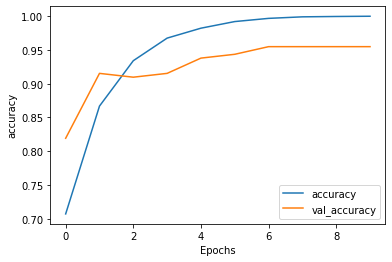

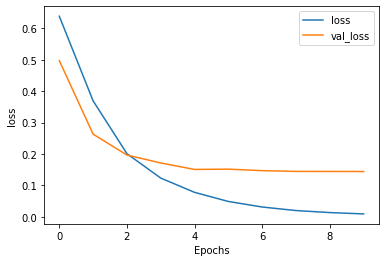

In [43]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### Predicting test data

In [44]:
test_sequences = tokenizer.texts_to_sequences(np.array(test.text))  # test dataset also sequenced using previously defined tokenizer instance
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen = max_length)

In [45]:
preds = np.round(model.predict(test_padded))

In [46]:
len(preds) #no. of test set data

444

In [47]:
acc = np.sum(1 if i==j else 0 for i,j in zip(preds, test["label"].replace('FAKE',1).replace('REAL',0).values)) / len(test)
print("Accuracy: ", acc )

Accuracy:  0.9617117117117117


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """Entry point for launching an IPython kernel.


### Plotting the confusion matrix

In [48]:
from sklearn.metrics import confusion_matrix

In [49]:
TN, FP, FN, TP = confusion_matrix(test["label"].replace('FAKE',1).replace('REAL',0).values, preds).ravel()
cm = confusion_matrix(test["label"].replace('FAKE',1).replace('REAL',0).values, preds)

(0.0, 1.0, 0.0, 1.0)

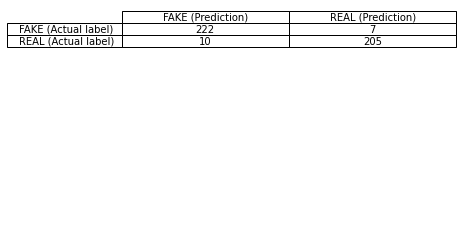

In [51]:
plt.table(cellText=[[TP,FN],[FP,TN]],cellLoc='center',colWidths=[0.5,0.5],rowLabels=['FAKE (Actual label)','REAL (Actual label)'],colLabels=['FAKE (Prediction)','REAL (Prediction)'],loc=0)
plt.axis('off')